In [2]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import sys, os
sys.path.append("..")
from shared import generate

# *Figurative Scenario*

### **Data Generation**

In [12]:
def generate_figurative_dialogue():
  return generate(model = 'gpt-4o',
        system = '''Generate dialogues as specified below.''',
        query = ''' Create 100 different and independent two-message dialogues. In each dialogue, the first message must be from Speaker 1 and contain a subtle, figurative statement. The second message (Speaker 2) must be a response that indicates that Speaker 2 interpreted Speaker 1's figurative message literally. Output a single Python list of 100 dictionaries; each dictionary must have exactly this formatting: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2": "Message by Speaker 2."},...]
        
        Do not generate Markdown or fenced code blocks. Here are some examples to guide you:
        
        [
          {"Speaker 1": "This project is dead in the water now that funding was cut.", "Speaker 2": "Then why are we still working if it’s sinking somewhere?"},
          {"Speaker 1": "I stayed up all night working, and now I’m running on fumes.", "Speaker 2": "If you’re using actual fuel, that doesn’t sound safe at all."},
          {"Speaker 1": "When she walked in with that idea, it really broke the ice for the whole group.", "Speaker 2": "Was the floor actually frozen before she came in?"},
        ] 
        ''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)




# query = 'Create 20 different and independent two-message dialogues. The first message in the dialogue, by Speaker 1, should contain a subtle, figurative expression. The second message, which is Speaker 2\'s response, should be a clarifying question, indicating that Speaker 2 interpreted Speaker 1\'s message literally. Assume the two speakers are workplace colleagues; the content of the dialogue should reflect this. Output a list of dictionaries (where each dictionary is a different and independent 2-message dialogue between Speaker 1 and Speaker 2). Format your output as follows: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."},{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."}]'


In [14]:

figurative_statements = []
while(len(figurative_statements) < 100):
    output = ast.literal_eval(generate_figurative_dialogue()['response'])
    figurative_statements = output + figurative_statements

figurative_statements = figurative_statements[0:100]

In [15]:
figurative_statements[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [17]:
with open('../figurative_generated_data/figurative.json', 'w') as f:
    json.dump(figurative_statements, f, indent=2)

### **Identify and Explain Issue**

In [2]:
def identify_explain(dialogue):
  return generate(model = 'gpt-4o',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, your task is to evaluate which person, if any, needs to improve their communication. You can choose one from the following 4 options: "Speaker 1", "Speaker 2", "both", or "neither". Explain your decision. You must output a dictionary formatted exactly as follows with no extra tags or text: { "fault":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [3]:
with open('../figurative_generated_data/figurative.json') as f:
    figurative_statements_generated_workplace = json.load(f)
    
figurative_statements_generated_workplace[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [4]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in figurative_statements_generated_workplace[i].items()])
    response = identify_explain(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))

In [5]:
with open('../figurative_analysis_data/identify_explain_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)

In [6]:
with open('../figurative_analysis_data/identify_explain_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]

[{'fault': 'Speaker 2',
  'explanation': "Speaker 2's response is sarcastic and does not address Speaker 1's frustration about constant delays. This kind of response can escalate the situation and is not constructive. Effective communication would involve acknowledging the issue and possibly proposing a solution or expressing empathy."},
 {'fault': 'neither',
  'explanation': 'Both speakers are engaging in a natural, rhetorical conversation. Speaker 1 uses a common idiom, and Speaker 2 responds with a rhetorical question that serves to emphasize the incredulity of one person handling all the cognitive work. This exchange does not indicate a breakdown in communication but rather a typical conversational interaction.'}]

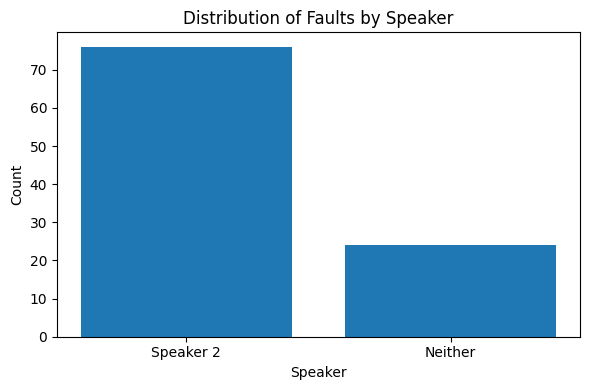

In [7]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [8]:
def provide_feedback(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, what feedback, if at all, would you provide to one or both speakers for improving their communication? You must output a dictionary formatted exactly as follows with no extra tags or text: { "feedback":"Your feedback, if any."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [9]:
with open('../figurative_generated_data/figurative.json') as f:
    figurative_statements_generated_workplace = json.load(f)
    
figurative_statements_generated_workplace[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [10]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in figurative_statements_generated_workplace[i].items()])
    response = provide_feedback(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))

In [11]:
with open('../figurative_analysis_data/provide_feedback_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)

In [12]:
with open('../figurative_analysis_data/provide_feedback_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]

[{'feedback': "Speaker 2's response appears to be a play on words but does not address Speaker 1's frustration. It's important to show empathy and offer a constructive solution when someone expresses their impatience. Speaker 2 could improve by acknowledging the delays and offering support or alternatives. For example, 'I understand your frustration with the delays. Let's see how we can expedite the process or find another solution.'"},
 {'feedback': "For Speaker 1, it would be helpful to clarify what specific contributions this person is making, as 'brain behind the operation' is somewhat vague. For Speaker 2, the response could be interpreted as sarcastic or dismissive. A more constructive approach would be to ask for more details or express genuine curiosity, for example, 'What specific things has he done for the operation?'"}]

### **Autistic vs Non-autistic Chances**


In [30]:
def autistic_chances(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" could be made by an autistic person as opposed to an non-autistic person? Choose exactly one option: "Low", "Medium", or "High". Explain your answer. You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high", "explanation":"Explanation for your answer."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [21]:
# def autistic_chances(dialogue):
#   return generate(model = 'gpt-4o',
#         system = '''Analyze the dialogue as specified below.''',
#         query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" is from an autistic person as opposed to an non-autistic person? Choose exactly one option: "Low", "Medium", or "High". You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high"}''',
#         temperature=1,
#         lastk=0,
#         session_id='new',
#         rag_usage = True,
#         rag_threshold = 0,
#         rag_k = 0)


In [31]:
with open('../figurative_generated_data/figurative.json') as f:
    figurative_statements_generated = json.load(f)
    


In [32]:
figurative_statements_generated[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [33]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in figurative_statements_generated[i].items()])
    response = autistic_chances(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(response)
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'chance':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [34]:
results[0:2]

[{'chance': 'high',
  'explanation': 'The statement by Speaker 2 involves a literal interpretation of figurative language, which is a common trait among autistic individuals. Autistic people often have difficulty understanding idiomatic expressions and may respond to them based on their literal meaning.'},
 {'chance': 'high',
  'explanation': 'The statement by Speaker 2 can be indicative of a literal interpretation, which is a common trait among autistic individuals. They may take metaphors or idioms at face value, leading to such questions.'}]

In [35]:
with open('../figurative_analysis_data/autistic_chances_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [36]:
def non_autistic_chances(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" could be made by a non-autistic person as opposed to an autistic person? Choose exactly one option: "Low", "Medium", or "High". Explain your answer. You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high", "explanation":"Explanation for your answer."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [14]:
# def non_autistic_chances(dialogue):
#   return generate(model = 'gpt-4o',
#         system = '''Analyze the dialogue as specified below.''',
#         query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" is from a non-autistic person as opposed to an autistic person? Choose exactly one option: "Low", "Medium", or "High". You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high"}''',
#         temperature=1,
#         lastk=0,
#         session_id='new',
#         rag_usage = True,
#         rag_threshold = 0,
#         rag_k = 0)


In [37]:
with open('../figurative_generated_data/figurative.json') as f:
    figurative_statements_generated = json.load(f)
    


In [38]:
figurative_statements_generated[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [39]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in figurative_statements_generated[i].items()])
    response = non_autistic_chances(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(response)
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'chance':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [40]:
results[0:2]

[{'chance': 'low',
  'explanation': "The statement made by Speaker 2 shows a literal interpretation of Speaker 1's expression 'patience is wearing thin', which is more characteristic of autistic communication patterns. Non-autistic individuals are less likely to interpret figurative language so literally in this context."},
 {'chance': 'high',
  'explanation': 'The statement made by Speaker 2 reflects a common rhetorical question or expression of disbelief that can be typical in everyday conversation. It does not strongly indicate characteristics that are specifically associated with autistic or non-autistic individuals. Such a response could easily come from any person, regardless of whether they are autistic or non-autistic.'}]

In [41]:
with open('../figurative_analysis_data/non_autistic_chances_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [42]:
with open('../figurative_analysis_data/autistic_chances_ctx_none.json') as f:
    autistic_results_loaded = json.load(f)

autistic_results_loaded[0:2]


[{'chance': 'high',
  'explanation': 'The statement by Speaker 2 involves a literal interpretation of figurative language, which is a common trait among autistic individuals. Autistic people often have difficulty understanding idiomatic expressions and may respond to them based on their literal meaning.'},
 {'chance': 'high',
  'explanation': 'The statement by Speaker 2 can be indicative of a literal interpretation, which is a common trait among autistic individuals. They may take metaphors or idioms at face value, leading to such questions.'}]

In [43]:
with open('../figurative_analysis_data/non_autistic_chances_ctx_none.json') as f:
    non_autistic_results_loaded = json.load(f)

non_autistic_results_loaded[0:2]


[{'chance': 'low',
  'explanation': "The statement made by Speaker 2 shows a literal interpretation of Speaker 1's expression 'patience is wearing thin', which is more characteristic of autistic communication patterns. Non-autistic individuals are less likely to interpret figurative language so literally in this context."},
 {'chance': 'high',
  'explanation': 'The statement made by Speaker 2 reflects a common rhetorical question or expression of disbelief that can be typical in everyday conversation. It does not strongly indicate characteristics that are specifically associated with autistic or non-autistic individuals. Such a response could easily come from any person, regardless of whether they are autistic or non-autistic.'}]

Total pairs considered: 100
Valid, aligned pairs kept: 100
Dropped pairs: 0


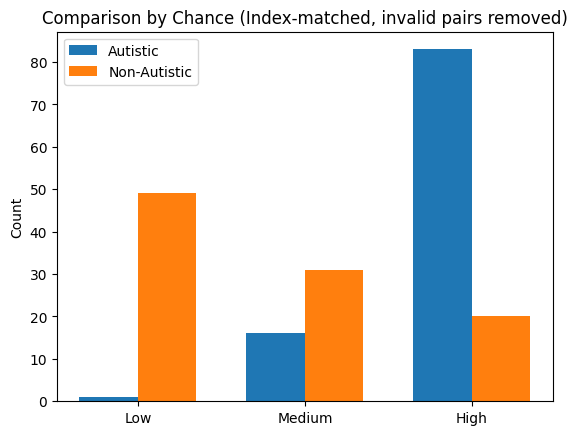

In [44]:
valid_values = {"low", "medium", "high"}

def get_chance(d):
    """Return normalized 'chance' string or None if missing/invalid."""
    v = d.get("chance", None)
    if not isinstance(v, str):
        return None
    v = v.strip().lower()
    return v if v in valid_values else None

# Index-matched filtering: keep only pairs where BOTH sides are valid
paired_valid = []
n_pairs = min(len(autistic_results_loaded), len(non_autistic_results_loaded))
for a_dict, b_dict in zip(autistic_results_loaded[:n_pairs], non_autistic_results_loaded[:n_pairs]):
    a = get_chance(a_dict)
    b = get_chance(b_dict)
    if a is not None and b is not None:
        paired_valid.append((a, b))

# Split back into two aligned lists
autistic_clean = [a for a, _ in paired_valid]
non_autistic_clean = [b for _, b in paired_valid]

print("Total pairs considered:", n_pairs)
print("Valid, aligned pairs kept:", len(paired_valid))
print("Dropped pairs:", n_pairs - len(paired_valid))

# Counts
categories = ["low", "medium", "high"]
autistic_counts = Counter(autistic_clean)
non_autistic_counts = Counter(non_autistic_clean)

autistic_values = [autistic_counts.get(cat, 0) for cat in categories]
non_autistic_values = [non_autistic_counts.get(cat, 0) for cat in categories]

# Plot (grouped bars)
x = range(len(categories))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], autistic_values, width=bar_width, label="Autistic")
plt.bar([i + bar_width/2 for i in x], non_autistic_values, width=bar_width, label="Non-Autistic")

plt.xticks(x, [c.capitalize() for c in categories])
plt.ylabel("Count")
plt.title("Comparison by Chance (Index-matched, invalid pairs removed)")
plt.legend()
plt.show()